In [77]:
from __future__ import absolute_import, division, print_function, unicode_literals
from pprint import pprint
from sklearn.linear_model import LinearRegression as LR
from IPython.core.display import display, HTML
from scipy.stats.mstats import gmean 
import argparse, logging, tempfile, json, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.max_open_warning'] = 100
pd.options.mode.chained_assignment = None

display(HTML("<style>.container { width:100% !important; }</style>"))

In [88]:
# Util functions
def div_round_up(x, y):
    return (x + y - 1) // y

def error_mean_std(predicted, actual):
    error = (predicted - actual).abs() / actual
    return error.mean(), error.std()

def p2f(x):
    return float(x.strip('%')) / 100

def remove_bw_suffix(x):
    if x.endswith('GB/s'):
        return float(x.strip('GB/s'))
    elif x.endswith('MB/s'):
        return float(x.strip('MB/s')) / 1000
    # B/s
    return float(x.strip('B/s')) / 1000000000

def strip_util(x):
    return float(x.strip('(').strip(')'))

def preprocessing(stats):
    stats = stats.dropna()
    for col in ['gld_efficiency', 'gst_efficiency', 'flop_sp_efficiency', 'flop_dp_efficiency', 'shared_efficiency', 'warp_execution_efficiency', 'sm_efficiency', "l2_tex_hit_rate"]:
        if col in stats.columns:
            stats[col] = stats[col].apply(p2f)
    for col in ['dram_read_throughput', 'dram_write_throughput', 'l2_read_throughput', 'l2_write_throughput', 'shared_load_throughput', 'shared_store_throughput']:
        if col in stats.columns:
            stats[col] = stats[col].apply(remove_bw_suffix)
    for col in ['dram_utilization', 'l2_utilization', 'shared_utilization']:
        if col in stats.columns:
            stats[col] = stats[col].apply(strip_util)
    return stats

def histogram(df, buckets, percentage=True):
    for idx, bk in enumerate(buckets):
        if idx > 0:
            if percentage:
                print("{}-{}%, {:.2f}%".format(buckets[idx-1] * 100, bk * 100, 100 * len(df[(df.abs() < bk) & (df.abs() > buckets[idx-1])]) / len(df)))
            else:
                print("{}-{}, {:.2f}%".format(buckets[idx-1], bk, 100 * len(df[(df < bk) & (df > buckets[idx-1])]) / len(df)))
                
# hit_rate = C(X, L) / C(E, L), X = avg_num_rows_per_table
def hit_rate(X, E, L):
    ret = 1.0
    e = E
    x = X
    for idx in range(L):
        ret *= x / e
        x -= 1
        e -= 1
    return ret

### Tesla V100:
- DRAM BW: 800~900 GB/s
- L2 BW: 2800~2900 GB/s
- SMEM BW: ~3900 GB/s
- Peak throughput: ~12200 GFLOPS
- \# of SM: 80
- L2 cache size: 6291456 Bytes

In [80]:
peak_dram_bw = 809
peak_l2_bw = 2888
peak_throughput = 12200
num_SM = 80
L2_size = 6 * 1024 * 1024 * 4

In [81]:
#
EL_forward = pd.read_csv("./embedding_lookup_forward.csv", delimiter=',')
EL_forward = preprocessing(EL_forward)
EL_forward = EL_forward[EL_forward["kernel_name"].str.startswith("batch")]

#
EL_forward_shmem = pd.read_csv("./embedding_lookup_forward_shmem.csv", delimiter=',')
EL_forward_shmem = preprocessing(EL_forward_shmem)
EL_forward_shmem = EL_forward_shmem[EL_forward_shmem["kernel_name"].str.startswith("batch")]

# 
EL_backward_raa = pd.read_csv("./embedding_lookup_backward_rowwise_adagrad_approx.csv", delimiter=',')
EL_backward_raa = preprocessing(EL_backward_raa)
EL_backward_raa = EL_backward_raa[EL_backward_raa["kernel_name"].str.startswith("batch")]

#
EL_backward_sgd = pd.read_csv("./embedding_lookup_backward_sgd.csv", delimiter=',')
EL_backward_sgd = preprocessing(EL_backward_sgd)
EL_backward_sgd = EL_backward_sgd[EL_backward_sgd["kernel_name"].str.startswith("batch")]

#
EL_backward_sgd_shmem = pd.read_csv("./embedding_lookup_backward_sgd_shmem.csv", delimiter=',')
EL_backward_sgd_shmem = preprocessing(EL_backward_sgd_shmem)
EL_backward_sgd_shmem = EL_backward_sgd_shmem[EL_backward_sgd_shmem["kernel_name"].str.startswith("batch")]


for df in [EL_forward, EL_forward_shmem, EL_backward_raa, EL_backward_sgd, EL_backward_sgd_shmem]:
    df["dram_bytes"] = (df["dram_read_transactions"] + df["dram_write_transactions"]) * 32
    df["l2_bytes"] = (df['l2_read_transactions'] + df['l2_write_transactions']) * 32

## Performance model

In [17]:
EL_forward.columns

Index(['kernel_name', 'batch_size', 'num_embeddings', 'num_tables', 'bag_size',
       'embedding_dim', 'rows_per_block', 'kernel_runtime', 'op_runtime',
       'flop_count_dp', 'flop_count_dp_add', 'flop_count_dp_fma',
       'flop_count_dp_mul', 'flop_count_sp', 'flop_count_sp_add',
       'flop_count_sp_fma', 'flop_count_sp_mul', 'flop_count_sp_special',
       'flop_sp_efficiency', 'flop_dp_efficiency', 'dram_read_transactions',
       'dram_write_transactions', 'dram_read_throughput',
       'dram_write_throughput', 'dram_utilization', 'dram_read_bytes',
       'dram_write_bytes', 'l2_global_load_bytes',
       'l2_local_global_store_bytes', 'l2_local_load_bytes',
       'l2_read_transactions', 'l2_write_transactions', 'l2_read_throughput',
       'l2_write_throughput', 'l2_utilization', 'shared_load_transactions',
       'shared_store_transactions', 'shared_load_throughput',
       'shared_store_throughput', 'shared_efficiency', 'shared_utilization',
       'gld_transactions', 'g

### Transactions and bytes
- Each DRAM and L2 transaction is 32 bytes.

In [18]:
bytes_per_transaction_dram_read = EL_forward["dram_read_bytes"] / EL_forward["dram_read_transactions"]
print(bytes_per_transaction_dram_read.mean(), bytes_per_transaction_dram_read.std())
bytes_per_transaction_dram_write = EL_forward["dram_write_bytes"] / EL_forward["dram_write_transactions"]
print(bytes_per_transaction_dram_write.mean(), bytes_per_transaction_dram_write.std())
bytes_per_transaction_l2_read = (EL_forward["l2_global_load_bytes"] + EL_forward["l2_local_load_bytes"]) / EL_forward["l2_read_transactions"]
print(bytes_per_transaction_l2_read.mean(), bytes_per_transaction_l2_read.std())
bytes_per_transaction_l2_write = EL_forward["l2_local_global_store_bytes"] / EL_forward["l2_write_transactions"]
print(bytes_per_transaction_l2_write.mean(), bytes_per_transaction_l2_write.std())

32.00000297809041 9.977221022900295e-05
32.00003256498417 4.889704077858251e-05
31.996472867807995 0.012580878898850026
30.256473260495643 2.4907829268902018


- In most of the cases tables doesn't fit in cache. DRAM latency dominates most of the cases.
- In a few cases dram_bytes are much less than l2 bytes, while in most of the cases they are similar. Generally but not always, l2_bytes is inclusive to dram_bytes. It's **not reasonable** to add them up.

In [19]:
weights_size = EL_forward["num_embeddings"] * EL_forward["num_tables"] * EL_forward["embedding_dim"]
DRAM_dom = EL_forward[(weights_size * 4 > 6 * 1024 * 1024 * 2) & (EL_forward["num_embeddings"] > 0)]
print(len(EL_forward), len(DRAM_dom))
DRAM_latency = EL_forward["dram_bytes"] / peak_dram_bw / 1000
l2_latency = EL_forward["l2_bytes"] / peak_l2_bw / 1000
(DRAM_latency > l2_latency).count()

5844 5700


5844

### Embedding lookup forward shmem / no-shmem

In [94]:
l = {
    "forward_no_shmem": EL_forward[EL_forward["num_embeddings"] >= 0], # Test different E here, same below
    "forward_shmem": EL_forward_shmem[EL_forward_shmem["num_embeddings"] >= 0],
}

# def get_num_warp_to_fill_avg_table_size(L, E, B, limited):
#     def num_rows_in_cache(n, L, E):
#         return n * L - \
#                 n * (n-1) * L * L / 2 / E + \
#                 n * (n-1) * (n-2) * L * L * L / 3 / 2 / E / E
#     if B * L < limited:
#         return B
#     n = 0
#     while n < B:
#         if num_rows_in_cache(n, L, E) > limited:
#             break
#         n += 1
#     return n

for t, y in l.items():
    print("#####", t, "#####")
    
    num_total_warps = y["batch_size"] * y["num_tables"] # Total warp number of the kernel
    num_warps_per_sm = y["rows_per_block"] # Number of warps per sm
    num_warps_simul = num_SM * num_warps_per_sm # Total number of warps simultaneously running on the device
    num_tables_simul = (num_warps_simul + y["batch_size"] - 1) // y["batch_size"] # Number of tables simultaneously being accessed on the device
    avg_table_size = pd.concat([L2_size // num_tables_simul, y["num_embeddings"] * y["embedding_dim"] * 4], axis=1).min(axis=1) # Average table size that reside on the device
    indices_size = 0 if t == "forward_shmem" else (y["bag_size"] * 4 + (32-1)) // 32 * 32
    avg_num_rows_per_table = (avg_table_size - indices_size) // 4 // y["embedding_dim"]

    # Hit rate
    tmp_df = pd.DataFrame()
    tmp_df['X'] = avg_num_rows_per_table
    tmp_df['E'] = y["num_embeddings"]
    tmp_df['L'] = y["bag_size"]
    hr = tmp_df.apply(lambda x: hit_rate(x['X'], x['E'], x['L']), axis=1)

    # num_thread_x
    tmp_df = pd.DataFrame()
    tmp_df['A'] = y["embedding_dim"] / 4
    tmp_df['B'] = 1024 / y["rows_per_block"]
    num_thread_x = tmp_df[['A', 'B']].min(axis=1)

    # Traffics
    table_offsets_traffic = 32
    offsets_traffic = 32
    if t == "forward_shmem":
        indices_dram_traffic = ((y["bag_size"] * 4 + (32-1)) // 32 * 32)
        indices_l2_traffic = 0
    else: # "forward_no_shmem"
        indices_dram_traffic = (y["bag_size"] * 4 + (32-1)) // 32 * 32
        indices_l2_traffic = (y["embedding_dim"] // (4 * num_thread_x)) * ((y["bag_size"] * 4 + (32-1)) // 32 * 32)
    table_traffic = y["bag_size"] * ((y["embedding_dim"] * 4 + (32-1)) // 32 * 32)
    output_traffic = ((y["embedding_dim"] * 4 + (32-1)) // 32 * 32)

    # Estimated total traffic as all from dram
    print("---- Total traffic as DRAM traffic ----")
    # Traffic per warp = t_offsets + t_table_offsets + t_indices + t_weights + t_outputs
    total_traffic_per_warp = table_offsets_traffic + \
                            offsets_traffic + \
                            indices_dram_traffic + indices_l2_traffic + \
                            table_traffic + \
                            output_traffic
    # Traffic = warp * traffic per warp
    total_traffic = y["batch_size"] * y["num_tables"] * total_traffic_per_warp
    
    ratio = (total_traffic / peak_dram_bw / 1000 - y["kernel_runtime"]) / y["kernel_runtime"]
    histogram(ratio, [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0, 2.0, 3.0, 4.0])
    print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmean(abs(ratio)) * 100, abs(ratio).mean() * 100, abs(ratio).std() * 100))
    
    # avg_table_size all as dram traffic
    print("---- Split DRAM/L2 traffic + hit rate estimation ----")
    total_l2_traffic = ((table_offsets_traffic + offsets_traffic + indices_l2_traffic) * y["batch_size"] + \
                        hr * (table_traffic * y["batch_size"] - avg_table_size)) * y["num_tables"]
    total_dram_traffic = ((indices_dram_traffic + output_traffic) * y["batch_size"] + \
                          (1 - hr) * (table_traffic * y["batch_size"] - avg_table_size) + avg_table_size) * y["num_tables"]
    
    tmp_df = pd.concat([total_dram_traffic / peak_dram_bw / 1000.0, total_l2_traffic / peak_l2_bw / 1000.0], axis=1)
    estimated_time = tmp_df.apply(lambda x: max(x[0], x[1]), axis=1)

    ratio = (estimated_time - y["kernel_runtime"]) / y["kernel_runtime"]
    histogram(ratio, [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0, 2.0, 3.0, 4.0])
    print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmean(abs(ratio)) * 100, abs(ratio).mean() * 100, abs(ratio).std() * 100))

    # # Table traffic = avg_table_size (batch b1) + else (batch b2), where b1 + b2 = B
    # # Failed
    # initial_stage_num_warps = pd.concat([y['bag_size'], y['num_embeddings'], y['batch_size'], avg_num_rows_per_table], axis=1).apply(lambda x: get_num_warp_to_fill_avg_table_size(x['bag_size'], x['num_embeddings'], x['batch_size'], x[0]), axis=1)
    # b1 = initial_stage_num_warps
    # stage_2_traffic = table_traffic * (y["batch_size"] - b1)
    # stage_1_l2_traffic = b1 * table_traffic - avg_table_size
    # stage_1_dram_traffic = avg_table_size
    # stage_2_l2_traffic = hr * stage_2_traffic
    # stage_2_dram_traffic = (1 - hr) * stage_2_traffic
    # total_l2_traffic = y["num_tables"] * ((table_offsets_traffic + offsets_traffic) * y["batch_size"] + \
    #                     stage_1_l2_traffic + stage_2_l2_traffic)
    # total_dram_traffic = y["num_tables"] * ((indices_traffic + output_traffic) * y["batch_size"] + \
    #                       stage_1_dram_traffic + stage_2_dram_traffic)

##### forward_no_shmem #####
---- Total traffic as DRAM traffic ----
0.0-5.0%, 19.75%
5.0-10.0%, 15.06%
10.0-15.0%, 8.62%
15.0-20.0%, 4.88%
20.0-25.0%, 3.39%
25.0-30.0%, 3.85%
30.0-100.0%, 18.53%
100.0-200.0%, 12.08%
200.0-300.0%, 11.09%
300.0-400.0%, 2.17%
GMAE: 22.24%, mean: 70.46%, std: 94.17%
---- Split DRAM/L2 traffic + hit rate estimation ----
0.0-5.0%, 24.85%
5.0-10.0%, 18.58%
10.0-15.0%, 11.64%
15.0-20.0%, 7.58%
20.0-25.0%, 6.21%
25.0-30.0%, 4.72%
30.0-100.0%, 25.60%
100.0-200.0%, 0.82%
200.0-300.0%, 0.00%
300.0-400.0%, 0.00%
GMAE: 10.88%, mean: 20.28%, std: 20.63%
##### forward_shmem #####
---- Total traffic as DRAM traffic ----
0.0-5.0%, 15.95%
5.0-10.0%, 22.05%
10.0-15.0%, 9.78%
15.0-20.0%, 5.49%
20.0-25.0%, 4.52%
25.0-30.0%, 4.07%
30.0-100.0%, 16.40%
100.0-200.0%, 8.58%
200.0-300.0%, 12.11%
300.0-400.0%, 1.02%
GMAE: 20.57%, mean: 61.55%, std: 86.23%
---- Split DRAM/L2 traffic + hit rate estimation ----
0.0-5.0%, 20.85%
5.0-10.0%, 25.77%
10.0-15.0%, 13.15%
15.0-20.0%, 7.05%


### Embedding lookup backward sgd shmem / no-shmem

In [100]:
l = {
    "backward_sgd_no_shmem": EL_backward_sgd[EL_backward_sgd["num_embeddings"] >= 0],
    "backward_sgd_shmem": EL_backward_sgd_shmem[EL_backward_sgd_shmem["num_embeddings"] >= 0], # 40% error, something wrong.
}

for t, y in l.items():
    print(t)
    
    num_total_warps = y["batch_size"] * y["num_tables"] # Total warp number of the kernel
    num_warps_per_sm = y["rows_per_block"] # Number of warps per sm
    num_warps_simul = num_SM * num_warps_per_sm # Total number of warps simultaneously running on the device
    num_tables_simul = (num_warps_simul + y["batch_size"] - 1) // y["batch_size"] # Number of tables simultaneously being accessed on the device
    avg_table_size = pd.concat([L2_size // num_tables_simul, y["num_embeddings"] * y["embedding_dim"] * 4], axis=1).min(axis=1) # Average table size that reside on the device
    indices_size = 0 if t == "forward_shmem" else (y["bag_size"] * 4 + (32-1)) // 32 * 32
    avg_num_rows_per_table = (avg_table_size - indices_size) // 4 // y["embedding_dim"] - 1 # (one row for grad output)
    
    # Hit rate
    tmp_df = pd.DataFrame()
    tmp_df['X'] = avg_num_rows_per_table
    tmp_df['E'] = y["num_embeddings"]
    tmp_df['L'] = y["bag_size"]
    hr = tmp_df.apply(lambda x: hit_rate(x['X'], x['E'], x['L']), axis=1)
    
    # Traffics
    table_offsets_traffic = 32
    offsets_traffic = 32
    if t == "backward_sgd_shmem":
        indices_traffic = ((y["bag_size"] * 4 + (32-1)) // 32 * 32)
        grad_output_dram_traffic = (y["embedding_dim"] * 4 + (32-1)) // 32 * 32
        grad_output_l2_traffic = 0
    else: # backward_sgd_no_shmem
        indices_traffic = y["bag_size"] * 32
        grad_output_dram_traffic = ((y["embedding_dim"] * 4 + (32-1)) // 32) * 32 * 2
        grad_output_l2_traffic = ((y["bag_size"] - 1) * ((y["embedding_dim"] * 4 + (32-1)) // 32) * 32) * 2
    half_table_traffic = y["bag_size"] * ((y["embedding_dim"] * 4 + (32-1)) // 32 * 32)
    
    # Estimated total traffic as all from dram
    print("---- Total traffic as DRAM traffic ----")
    # Traffic per warp = t_offsets + t_table_offsets + t_indices + t_weights + t_grad_outputs
    total_traffic_per_warp = table_offsets_traffic + \
                            offsets_traffic + \
                            indices_traffic + \
                            2 * half_table_traffic + \
                            grad_output_dram_traffic + grad_output_l2_traffic
    
    # Traffic = warp * traffic per warp
    total_traffic = y["batch_size"] * y["num_tables"] * total_traffic_per_warp
    
#     # Weird: total_traffic is much less than L2 bytes
#     plt.figure()
#     plt.plot(total_traffic / y["l2_bytes"])

    ratio = (total_traffic / peak_dram_bw / 1000 - y["kernel_runtime"]) / y["kernel_runtime"]
    histogram(ratio, [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0, 2.0, 3.0, 4.0])
    print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmean(abs(ratio)) * 100, abs(ratio).mean() * 100, abs(ratio).std() * 100))
    
#     # Needs to debug.
#     # avg_table_size all as dram traffic
#     print("---- Split DRAM/L2 traffic + hit rate estimation ----")
#     total_l2_traffic = ((table_offsets_traffic + offsets_traffic + grad_output_l2_traffic) * y["batch_size"] + \
#                         (1 + hr) / 2 * (2 * half_table_traffic * y["batch_size"] - avg_table_size)) * y["num_tables"]
#     total_dram_traffic = ((indices_traffic + grad_output_dram_traffic) * y["batch_size"] + \
#                           (1 - hr) / 2 * (2 * half_table_traffic * y["batch_size"] - avg_table_size) + avg_table_size) * y["num_tables"]
    
#     tmp_df = pd.concat([total_dram_traffic / peak_dram_bw / 1000.0, total_l2_traffic / peak_l2_bw / 1000.0], axis=1)
#     estimated_time = tmp_df.apply(lambda x: max(x[0], x[1]), axis=1)

#     ratio = (estimated_time - y["kernel_runtime"]) / y["kernel_runtime"]
#     histogram(ratio, [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0, 2.0, 3.0, 4.0])
#     print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmean(abs(ratio)) * 100, abs(ratio).mean() * 100, abs(ratio).std() * 100))

backward_sgd_no_shmem
---- Total traffic as DRAM traffic ----
0.0-5.0%, 29.04%
5.0-10.0%, 23.46%
10.0-15.0%, 16.87%
15.0-20.0%, 6.26%
20.0-25.0%, 5.07%
25.0-30.0%, 2.72%
30.0-100.0%, 16.58%
100.0-200.0%, 0.00%
200.0-300.0%, 0.00%
300.0-400.0%, 0.00%
GMAE: 9.07%, mean: 15.64%, std: 16.56%
backward_sgd_shmem
---- Total traffic as DRAM traffic ----
0.0-5.0%, 0.00%
5.0-10.0%, 0.00%
10.0-15.0%, 0.33%
15.0-20.0%, 6.08%
20.0-25.0%, 3.48%
25.0-30.0%, 4.53%
30.0-100.0%, 85.59%
100.0-200.0%, 0.00%
200.0-300.0%, 0.00%
300.0-400.0%, 0.00%
GMAE: 40.64%, mean: 42.16%, std: 9.69%


In [38]:
x = EL_backward_sgd[EL_backward_sgd["num_embeddings"] >= 0]
x.tail()

,kernel_name,batch_size,num_embeddings,num_tables,bag_size,embedding_dim,rows_per_block,kernel_runtime,op_runtime,flop_count_dp,flop_count_dp_add,flop_count_dp_fma,flop_count_dp_mul,flop_count_sp,flop_count_sp_add,flop_count_sp_fma,flop_count_sp_mul,flop_count_sp_special,flop_sp_efficiency,flop_dp_efficiency,dram_read_transactions,dram_write_transactions,dram_read_throughput,dram_write_throughput,dram_utilization,dram_read_bytes,dram_write_bytes,l2_global_load_bytes,l2_local_global_store_bytes,l2_local_load_bytes,l2_read_transactions,l2_write_transactions,l2_read_throughput,l2_write_throughput,l2_utilization,shared_load_transactions,shared_store_transactions,shared_load_throughput,shared_store_throughput,shared_efficiency,shared_utilization,gld_transactions,gst_transactions,gld_efficiency,gst_efficiency,warp_execution_efficiency,sm_efficiency,achieved_occupancy,ipc,issued_ipc,inst_compute_ld_st,inst_per_warp,inst_executed,inst_issued,inst_fp_32,inst_fp_64,inst_integer,dram_bytes,l2_bytes
2757,batched_embedding_backward_sgd_kernel_1,4096,500000,32,16,128,32,5136.5,5169,0,0,0,0,5.368709e+08,0,2.684355e+08,0,4194304,0.0070,0.0,36304782,35364303,220.57,214.86,6.0,1.161753e+09,1.131658e+09,84036176,0,0,1.368417e+08,1.342669e+08,831.40,815.75,3.0,0,0,0.0,0.0,0.0,0.0,36044800,0,0.0086,0.0,1.0,0.9890,0.946687,0.170389,0.170449,4.152361e+08,766.0,100401152,100436663,2.726298e+08,0,1.849689e+09,2293410720,8.675475e+09
2758,batched_embedding_backward_sgd_kernel_1,4096,500000,32,32,128,32,9891.5,9905,0,0,0,0,1.073742e+09,0,5.368709e+08,0,4194304,0.0071,0.0,70704851,70934589,216.16,216.87,6.0,2.262555e+09,2.269907e+09,115786720,0,0,2.720953e+08,2.684842e+08,831.86,820.82,3.0,0,0,0.0,0.0,0.0,0.0,71696384,0,0.0080,0.0,1.0,0.9883,0.954242,0.163893,0.163940,8.178893e+08,1470.0,192675840,192730583,5.410652e+08,0,3.527411e+09,4532462080,1.729854e+10
2759,batched_embedding_backward_sgd_kernel_1,4096,500000,32,38,128,32,11538.0,11568,0,0,0,0,1.275068e+09,0,6.375342e+08,0,4194304,0.0071,0.0,83677577,84271017,214.79,216.31,6.0,2.677682e+09,2.696673e+09,125987312,0,0,3.226444e+08,3.188160e+08,828.19,818.37,3.0,0,0,0.0,0.0,0.0,0.0,85065728,0,0.0079,0.0,1.0,0.9890,0.956652,0.163018,0.163062,9.688842e+08,1734.0,227278848,227340740,6.417285e+08,0,4.156556e+09,5374355008,2.052673e+10
2760,batched_embedding_backward_sgd_kernel_1,4096,500000,32,64,128,32,19622.0,19620,0,0,0,0,2.147484e+09,0,1.073742e+09,0,4194304,0.0073,0.0,139602491,142482416,212.42,216.80,6.0,4.467280e+09,4.559437e+09,160315480,0,0,5.418978e+08,5.369510e+08,824.55,817.03,3.0,0,0,0.0,0.0,0.0,0.0,142999552,0,0.0077,0.0,1.0,0.9887,0.961349,0.164955,0.164995,1.623196e+09,2878.0,377225216,377318967,1.077936e+09,0,6.882854e+09,9026717024,3.452316e+10
2761,batched_embedding_backward_sgd_kernel_1,4096,500000,32,128,128,32,38814.0,38844,0,0,0,0,4.294967e+09,0,2.147484e+09,0,4194304,0.0071,0.0,277142948,285422023,211.71,218.03,6.0,8.868574e+09,9.133505e+09,261904896,0,0,1.081843e+09,1.073808e+09,826.42,820.28,3.0,0,0,0.0,0.0,0.0,0.0,285605888,0,0.0075,0.0,1.0,0.9877,0.963731,0.159154,0.159191,3.233808e+09,5694.0,746323968,746498492,2.151678e+09,0,1.359400e+10,18002079072,6.898084e+10


In [39]:
x = EL_backward_sgd_shmem[EL_backward_sgd_shmem["num_embeddings"] >= 0]
x.tail()

,kernel_name,batch_size,num_embeddings,num_tables,bag_size,embedding_dim,rows_per_block,kernel_runtime,op_runtime,flop_count_dp,flop_count_dp_add,flop_count_dp_fma,flop_count_dp_mul,flop_count_sp,flop_count_sp_add,flop_count_sp_fma,flop_count_sp_mul,flop_count_sp_special,flop_sp_efficiency,flop_dp_efficiency,dram_read_transactions,dram_write_transactions,dram_read_throughput,dram_write_throughput,dram_utilization,dram_read_bytes,dram_write_bytes,l2_global_load_bytes,l2_local_global_store_bytes,l2_local_load_bytes,l2_read_transactions,l2_write_transactions,l2_read_throughput,l2_write_throughput,l2_utilization,shared_load_transactions,shared_store_transactions,shared_load_throughput,shared_store_throughput,shared_efficiency,shared_utilization,gld_transactions,gst_transactions,gld_efficiency,gst_efficiency,warp_execution_efficiency,sm_efficiency,achieved_occupancy,ipc,issued_ipc,inst_compute_ld_st,inst_per_warp,inst_executed,inst_issued,inst_fp_32,inst_fp_64,inst_integer,dram_bytes,l2_bytes
2757,batched_embedding_backward_sgd_kernel_1,4096,500000,32,16,128,32,5194.0,5228,0,0,0,0,2.516582e+08,2.348810e+08,0,16777216,4194304,0.0032,0.0,37168891,40510157,221.57,241.49,6.0,1.189405e+09,1.296325e+09,76160592,0,0,1.365984e+08,1.342747e+08,814.30,800.44,3.0,2106640,133146,50.233,3.1749,0.0585,1.0,2752512,0,0.1131,0.0,0.9845,0.9888,0.933255,0.091486,0.091547,3.565158e+08,420.0,55050240,55087348,2.558525e+08,0,8.933877e+08,2485729536,8.667939e+09
2758,batched_embedding_backward_sgd_kernel_1,4096,500000,32,32,128,32,10019.0,10031,0,0,0,0,4.865393e+08,4.697620e+08,0,16777216,4194304,0.0031,0.0,72469865,82286967,217.84,247.35,6.0,2.319036e+09,2.633183e+09,84548536,0,0,2.710780e+08,2.684926e+08,814.86,807.09,3.0,4209692,134028,50.617,1.6115,0.0604,1.0,3014656,0,0.1902,0.0,1.0000,0.9895,0.946311,0.079374,0.079422,6.962545e+08,727.0,95289344,95347379,4.907336e+08,0,1.547699e+09,4952218624,1.726626e+10
2759,batched_embedding_backward_sgd_kernel_1,4096,500000,32,38,128,32,11920.0,11933,0,0,0,0,5.788140e+08,5.620367e+08,0,16777216,4194304,0.0032,0.0,85615398,98330862,214.92,246.84,6.0,2.739693e+09,3.146588e+09,86278504,0,0,3.215092e+08,3.188149e+08,807.08,800.31,3.0,4995589,267618,50.161,2.6872,0.0591,1.0,3264932,0,0.2057,0.0,0.9895,0.9882,0.946899,0.082275,0.082324,8.236564e+08,871.0,114163712,114231068,5.830083e+08,0,1.830028e+09,5886280320,2.049037e+10
2760,batched_embedding_backward_sgd_kernel_1,4096,500000,32,64,128,32,19798.0,19823,0,0,0,0,9.563013e+08,9.395241e+08,0,16777216,4194304,0.0032,0.0,144013336,166594445,215.05,248.77,6.0,4.608427e+09,5.331022e+09,101323840,0,0,5.400385e+08,5.369382e+08,806.42,801.79,3.0,8414654,266979,50.261,1.5947,0.0604,1.0,3538944,0,0.3102,0.0,1.0000,0.9891,0.955982,0.075924,0.075967,1.375732e+09,1353.0,177340416,177440297,9.604956e+08,0,2.852128e+09,9939448992,3.446325e+10
2761,batched_embedding_backward_sgd_kernel_1,4096,500000,32,128,128,32,39628.0,39667,0,0,0,0,1.895825e+09,1.879048e+09,0,16777216,4194304,0.0031,0.0,286020740,336189083,213.45,250.89,6.0,9.152664e+09,1.075800e+10,134879632,0,0,1.077959e+09,1.073792e+09,804.46,801.35,3.0,16822420,529885,50.217,1.5818,0.0604,1.0,4587520,0,0.4679,0.0,1.0000,0.9877,0.961366,0.072968,0.072996,2.734686e+09,2605.0,341442560,341574135,1.900020e+09,0,5.460985e+09,19910714336,6.885602e+10


In [236]:
x = EL_forward[EL_forward["num_embeddings"] >= 0]
x.head()

,kernel_name,batch_size,num_embeddings,num_tables,bag_size,embedding_dim,rows_per_block,kernel_runtime,op_runtime,flop_count_dp,flop_count_dp_add,flop_count_dp_fma,flop_count_dp_mul,flop_count_sp,flop_count_sp_add,flop_count_sp_fma,flop_count_sp_mul,flop_count_sp_special,flop_sp_efficiency,flop_dp_efficiency,dram_read_transactions,dram_write_transactions,dram_read_throughput,dram_write_throughput,dram_utilization,dram_read_bytes,dram_write_bytes,l2_global_load_bytes,l2_local_global_store_bytes,l2_local_load_bytes,l2_read_transactions,l2_write_transactions,l2_read_throughput,l2_write_throughput,l2_utilization,shared_load_transactions,shared_store_transactions,shared_load_throughput,shared_store_throughput,shared_efficiency,shared_utilization,gld_transactions,gst_transactions,gld_efficiency,gst_efficiency,warp_execution_efficiency,sm_efficiency,achieved_occupancy,ipc,issued_ipc,inst_compute_ld_st,inst_per_warp,inst_executed,inst_issued,inst_fp_32,inst_fp_64,inst_integer,dram_bytes,l2_bytes
0,batched_embedding_forward_kernel_1,128,1000,32,8,32,128,5.014,41,0,0,0,0,1048576.0,1048576.0,0,0,32768,0.0054,0.0,86832,34537,215.10,85.554,3.0,2778646.0,1105188,3023268.0,524288,0,94932,16468,235.16,40.794,1.0,0,0,0.0,0.0,0.0,0.0,168995,16384,0.1287,1.0,0.8929,0.2944,0.443186,0.714754,0.722434,655360.0,233.0,340845,343708,1081344.0,0,4555248.0,3883808,3564800
1,batched_embedding_forward_kernel_1,128,1000,32,8,64,64,7.531,36,0,0,0,0,2097152.0,2097152.0,0,0,65536,0.0083,0.0,173918,68240,328.81,129.010,5.0,5565389.0,2183689,7044384.0,1048576,0,220685,37223,417.22,70.374,1.0,0,0,0.0,0.0,0.0,0.0,302604,32768,0.1263,1.0,0.9286,0.5489,0.451209,0.492000,0.497099,1310720.0,233.0,545353,550641,2162688.0,0,9110496.0,7749056,8253056
2,batched_embedding_forward_kernel_1,128,1000,32,8,128,32,20.949,37,0,0,0,0,4194304.0,4194304.0,0,0,131072,0.0108,0.0,350983,115172,410.98,134.860,7.0,11231460.0,3685526,15430011.0,2097152,0,482658,74717,565.16,87.489,2.0,0,0,0.0,0.0,0.0,0.0,569344,65536,0.1250,1.0,1.0000,0.6864,0.451959,0.457988,0.461225,2621440.0,233.0,954368,961037,4325376.0,0,18220992.0,14916960,17836000
3,batched_embedding_forward_kernel_1,128,1000,32,8,256,16,40.397,56,0,0,0,0,8388608.0,8388608.0,0,0,262144,0.0128,0.0,693233,175586,464.86,117.740,7.0,22183465.0,5618774,32092708.0,4194304,0,1003207,146173,672.73,98.020,2.0,0,0,0.0,0.0,0.0,0.0,1138688,131072,0.1250,1.0,1.0000,0.8086,0.493435,0.462230,0.463878,5242880.0,233.0,1908736,1915518,8650752.0,0,36441984.0,27802208,36780160
4,batched_embedding_forward_kernel_1,128,1000,32,16,32,128,6.676,36,0,0,0,0,2097152.0,2097152.0,0,0,32768,0.0079,0.0,120831,52253,215.49,93.187,4.0,3866619.0,1672105,4660923.0,524288,0,146165,17025,260.67,30.364,1.0,0,0,0.0,0.0,0.0,0.0,332704,16384,0.0776,1.0,0.8929,0.3405,0.446503,0.708664,0.713290,1179648.0,369.0,539794,542498,2129920.0,0,7242224.0,5538688,5222080


In [254]:
x = EL_forward_shmem[EL_forward_shmem["num_embeddings"] >= 0]
x.head()

,kernel_name,batch_size,num_embeddings,num_tables,bag_size,embedding_dim,rows_per_block,kernel_runtime,op_runtime,flop_count_dp,flop_count_dp_add,flop_count_dp_fma,flop_count_dp_mul,flop_count_sp,flop_count_sp_add,flop_count_sp_fma,flop_count_sp_mul,flop_count_sp_special,flop_sp_efficiency,flop_dp_efficiency,dram_read_transactions,dram_write_transactions,dram_read_throughput,dram_write_throughput,dram_utilization,dram_read_bytes,dram_write_bytes,l2_global_load_bytes,l2_local_global_store_bytes,l2_local_load_bytes,l2_read_transactions,l2_write_transactions,l2_read_throughput,l2_write_throughput,l2_utilization,shared_load_transactions,shared_store_transactions,shared_load_throughput,shared_store_throughput,shared_efficiency,shared_utilization,gld_transactions,gst_transactions,gld_efficiency,gst_efficiency,warp_execution_efficiency,sm_efficiency,achieved_occupancy,ipc,issued_ipc,inst_compute_ld_st,inst_per_warp,inst_executed,inst_issued,inst_fp_32,inst_fp_64,inst_integer,dram_bytes,l2_bytes
0,batched_embedding_forward_kernel_1,128,1000,32,8,32,128,5.062,35,0,0,0,0,1048576.0,1048576.0,0,0,32768,0.0058,0.0,86765,32983,232.33,88.322,4.0,2776489.0,1055483,3014797.0,524288,0,94845,16530,253.97,44.265,1.0,11762,1462,125.99,15.669,0.1982,1.0,140342,16384,0.1552,1.0,0.8929,0.2990,0.450412,0.761522,0.775522,720896.0,238.0,348160,353149,1081344.0,0,4555248.0,3831936,3564000
1,batched_embedding_forward_kernel_1,128,1000,32,8,64,64,7.375,39,0,0,0,0,2097152.0,2097152.0,0,0,65536,0.0090,0.0,172550,68756,330.45,131.680,6.0,5521613.0,2200219,7032132.0,1048576,0,220316,36849,421.93,70.571,1.0,18810,2347,144.09,17.986,0.1030,1.0,273945,32768,0.1396,1.0,0.9033,0.5626,0.457613,0.534543,0.543796,1376256.0,239.0,559396,568590,2162688.0,0,8848352.0,7721792,8229280
2,batched_embedding_forward_kernel_1,128,1000,32,8,128,32,20.964,46,0,0,0,0,4194304.0,4194304.0,0,0,131072,0.0115,0.0,372938,99305,442.48,117.820,7.0,11934034.0,3177787,15610445.0,2097152,0,487291,81797,578.16,97.051,2.0,33017,4103,156.70,19.472,0.0552,1.0,540672,65536,0.1316,1.0,0.9613,0.7465,0.706507,0.461581,0.467749,2686976.0,239.0,978944,991987,4325376.0,0,17434560.0,15111776,18210816
3,batched_embedding_forward_kernel_1,128,1000,32,8,256,16,39.963,56,0,0,0,0,8388608.0,8388608.0,0,0,262144,0.0130,0.0,764113,173174,503.12,114.020,8.0,24451616.0,5541581,32421248.0,4194304,0,1013446,146020,667.29,96.145,2.0,65988,4124,173.80,10.863,0.0438,1.0,1077248,131072,0.1283,1.0,0.9802,0.7958,0.859120,0.474623,0.478542,5308416.0,233.0,1908736,1924479,8650752.0,0,34606976.0,29993184,37102912
4,batched_embedding_forward_kernel_1,128,1000,32,16,32,128,7.105,35,0,0,0,0,2097152.0,2097152.0,0,0,32768,0.0092,0.0,120497,50539,236.78,99.312,4.0,3855913.0,1617261,4682075.0,524288,0,146762,16808,288.39,33.030,1.0,37643,4688,295.88,36.851,0.1027,1.0,275385,16384,0.0938,1.0,0.8929,0.3352,0.455371,0.848333,0.858136,1310720.0,374.0,547108,551976,2129920.0,0,7143920.0,5473152,5234240


### Embedding lookup backward rowwise adagrad approx

In [65]:
DRAM_dom = EL_backward_raa[EL_backward_raa["num_embeddings"] >= 0]

tmp_df = pd.DataFrame()
tmp_df['A'] = DRAM_dom["embedding_dim"] / 4
tmp_df['B'] = 1024 / DRAM_dom["rows_per_block"]
num_thread_x = tmp_df[['A', 'B']].min(axis=1)
# Traffic = warp * traffic per warp
total_traffic_per_warp = 32 + \
                        32 + \
                        2 * ((DRAM_dom["bag_size"] * 4 + (32-1)) // 32 * 32) + \
                        DRAM_dom["bag_size"] * ((DRAM_dom["embedding_dim"] * 4 + (32-1)) // 32 * 32) + \
                        (DRAM_dom["bag_size"] + 1) * ((DRAM_dom["embedding_dim"] * 4 + (32-1)) // 32 * 32) + \
                        DRAM_dom["bag_size"] * ((DRAM_dom["embedding_dim"] * 4 + (32-1)) // 32 * 32)
total_traffic = DRAM_dom["batch_size"] * DRAM_dom["num_tables"] * total_traffic_per_warp

ratio = (total_traffic / peak_dram_bw / 1000 - DRAM_dom["kernel_runtime"]) / DRAM_dom["kernel_runtime"]
histogram(ratio, [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0, 2.0, 3.0, 4.0])
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmean(abs(ratio)) * 100, abs(ratio).mean() * 100, abs(ratio).std() * 100))

# r = total_traffic / (DRAM_dom["gld_transactions"] + DRAM_dom["gst_transactions"]) / 32
# plt.figure()
# plt.scatter(range(len(r)), r)

0.0-5.0%, 27.15%
5.0-10.0%, 11.88%
10.0-15.0%, 6.73%
15.0-20.0%, 6.88%
20.0-25.0%, 6.30%
25.0-30.0%, 5.50%
30.0-100.0%, 21.58%
100.0-200.0%, 6.15%
200.0-300.0%, 6.77%
300.0-400.0%, 1.05%
GMAE: 14.68%, mean: 46.50%, std: 71.69%


## Playing around with T

In [168]:
def get_B(E, T, L, D):
    E = E if isinstance(E, list) else [E]
    T = T if isinstance(T, list) else [T]
    L = L if isinstance(L, list) else [L]
    D = D if isinstance(D, list) else [D]
    return EL_forward[(EL_forward["num_embeddings"].isin(E)) & (EL_forward["num_tables"].isin(T)) & (EL_forward["bag_size"].isin(L)) & (EL_forward["embedding_dim"].isin(D))]

def get_E(B, T, L, D):
    B = B if isinstance(B, list) else [B]
    T = T if isinstance(T, list) else [T]
    L = L if isinstance(L, list) else [L]
    D = D if isinstance(D, list) else [D]
    return EL_forward[(EL_forward["batch_size"].isin(B)) & (EL_forward["num_tables"].isin(T)) & (EL_forward["bag_size"].isin(L) & (EL_forward["embedding_dim"].isin(D)))]

def get_T(B, E, L, D):
    B = B if isinstance(B, list) else [B]
    E = E if isinstance(E, list) else [E]
    L = L if isinstance(L, list) else [L]
    D = D if isinstance(D, list) else [D]
    return EL_forward[(EL_forward["batch_size"].isin(B)) & (EL_forward["num_embeddings"].isin(E)) & (EL_forward["bag_size"].isin(L)) & (EL_forward["embedding_dim"].isin(D))]

def get_D(B, E, T, L):
    B = B if isinstance(B, list) else [B]
    E = E if isinstance(E, list) else [E]
    T = T if isinstance(T, list) else [T]
    L = L if isinstance(L, list) else [L]
    return EL_forward[(EL_forward["batch_size"].isin(B)) & (EL_forward["num_embeddings"].isin(E)) & (EL_forward["num_tables"].isin(T)) & (EL_forward["bag_size"].isin(L))]

def total_size(df):
    indices_size = df["batch_size"] * df["num_tables"] * df["bag_size"]
    offsets_size = df["batch_size"] * df["num_tables"]
    weights_size = df["num_embeddings"] * df["num_tables"] * df["embedding_dim"]
    outputs_size = df["batch_size"] * df["num_tables"] * df["embedding_dim"]
    return indices_size + offsets_size + weights_size + outputs_size

def get_record(df, B, E, T, L, D, rows_per_block):
    B = B if isinstance(B, list) else [B]
    E = E if isinstance(E, list) else [E]
    T = T if isinstance(T, list) else [T]
    L = L if isinstance(L, list) else [L]
    D = D if isinstance(D, list) else [D]
    rows_per_block = rows_per_block if isinstance(rows_per_block, list) else [rows_per_block]
    return df[(df["batch_size"].isin(B)) & (df["num_embeddings"].isin(E)) & (df["num_tables"].isin(T)) & (df["bag_size"].isin(L)) & (df["embedding_dim"].isin(D)) & (df["rows_per_block"].isin(rows_per_block))]

### Varying B for T
Insights of B: There are 3 stages of DRAM bytes changes as B increases:
- DRAM bytes up because of cold miss of embedding table.
- DRAM bytes down because of embedding table residing in L2 cache.
- DRAM bytes up again because of cache conflicts.

L2 bytes always up as B increases.

Estimation of L2 bytes = B * T * L * D * 4

In [ ]:
for e in [1000, 5000, 10000, 20000, 100000]:
    for l in [8, 16, 32, 38, 64, 128]:
        for i, d in enumerate([32, 64, 128, 256]):
            if i % 2 == 0:
                fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(32,4))
            T_flex = get_T([128, 256, 512, 1024, 2048, 4096], e, l, d)
            T_flex = T_flex[['batch_size', 'num_embeddings', 'num_tables', 'bag_size', 'embedding_dim', 'rows_per_block', "dram_bytes", "l2_bytes", 'kernel_runtime']]
            T_flex['dram_bw'] = T_flex["dram_bytes"] / T_flex["kernel_runtime"] / 1000.0
            T_flex['l2_bw'] = T_flex["l2_bytes"] / T_flex["kernel_runtime"] / 1000.0
            T_flex['size'] = total_size(T_flex)
            T_flex = T_flex.sort_values(by=['batch_size', 'num_embeddings', 'num_tables', 'bag_size', 'embedding_dim', 'rows_per_block'])

            T_32 = T_flex[(T_flex["num_embeddings"] == e) & (T_flex["bag_size"] == l) & (T_flex["embedding_dim"] == d) & (T_flex["num_tables"] == 32)]
            T_32["total_bytes"] = T_32["dram_bytes"] + T_32["l2_bytes"]
            T_64 = T_flex[(T_flex["num_embeddings"] == e) & (T_flex["bag_size"] == l) & (T_flex["embedding_dim"] == d) & (T_flex["num_tables"] == 64)]
            T_64["total_bytes"] = T_64["dram_bytes"] + T_64["l2_bytes"]
            T_128 = T_flex[(T_flex["num_embeddings"] == e) & (T_flex["bag_size"] == l) & (T_flex["embedding_dim"] == d) & (T_flex["num_tables"] == 128)]
            T_128["total_bytes"] = T_128["dram_bytes"] + T_128["l2_bytes"]
            T_197 = T_flex[(T_flex["num_embeddings"] == e) & (T_flex["bag_size"] == l) & (T_flex["embedding_dim"] == d) & (T_flex["num_tables"] == 197)]
            T_197["total_bytes"] = T_197["dram_bytes"] + T_197["l2_bytes"]

            for idx, m in enumerate(["dram_bytes", "l2_bytes", "total_bytes", "kernel_runtime"]):
                handles = []
                h, = axs[idx + 4 * (i % 2)].plot(T_32["batch_size"], T_32[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_64["batch_size"], T_64[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_128["batch_size"], T_128[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_197["batch_size"], T_197[m])
                handles.append(h)
                axs[idx + 4 * (i % 2)].legend(handles, ["T=32", "T=64", "T=128", "T=197"], loc='best')
                axs[idx + 4 * (i % 2)].set(xlabel="B", ylabel=m)
                axs[idx + 4 * (i % 2)].set_title("(E, L, D) = ({}, {}, {})".format(e, l, d), fontsize=12)

### Varying E for T
As E increases, DRAM bytes up dramatically first because of cold miss and then flatten as the increase cold miss rate flatten.

L2 bytes remain roughly constant when E gets huge.

In [ ]:
for b in [128, 256, 512, 1024, 2048, 4096]:
    for l in [8, 16, 32, 38, 64]:
        for i, d in enumerate([32, 64, 128, 256]):
            if i % 2 == 0:
                fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(32,4))
            T_flex = get_T(b, [1000, 2000, 5000, 7500, 10000, 20000, 50000, 75000, 100000, 200000, 500000], l, d)
            T_flex = T_flex[['batch_size', 'num_embeddings', 'num_tables', 'bag_size', 'embedding_dim', 'rows_per_block', "dram_bytes", "l2_bytes", "l2_read_transactions", "l2_write_transactions", 'kernel_runtime']]
            T_flex['dram_bw'] = T_flex["dram_bytes"] / T_flex["kernel_runtime"] / 1000.0
            T_flex['l2_bw'] = T_flex["l2_bytes"] / T_flex["kernel_runtime"] / 1000.0
            T_flex['size'] = total_size(T_flex)
            T_flex['l2_tr'] = T_flex['l2_read_transactions'] + T_flex['l2_write_transactions']
            T_flex = T_flex.sort_values(by=['batch_size', 'num_embeddings', 'num_tables', 'bag_size', 'embedding_dim', 'rows_per_block'])

            T_32 = T_flex[(T_flex["batch_size"] == b) & (T_flex["bag_size"] == l) & (T_flex["embedding_dim"] == d) & (T_flex["num_tables"] == 32)]
            T_32["total_bytes"] = T_32["dram_bytes"] + T_32["l2_bytes"]
            T_64 = T_flex[(T_flex["batch_size"] == b) & (T_flex["bag_size"] == l) & (T_flex["embedding_dim"] == d) & (T_flex["num_tables"] == 64)]
            T_64["total_bytes"] = T_64["dram_bytes"] + T_64["l2_bytes"]
            T_128 = T_flex[(T_flex["batch_size"] == b) & (T_flex["bag_size"] == l) & (T_flex["embedding_dim"] == d) & (T_flex["num_tables"] == 128)]
            T_128["total_bytes"] = T_128["dram_bytes"] + T_128["l2_bytes"]
            T_197 = T_flex[(T_flex["batch_size"] == b) & (T_flex["bag_size"] == l) & (T_flex["embedding_dim"] == d) & (T_flex["num_tables"] == 197)]
            T_197["total_bytes"] = T_197["dram_bytes"] + T_197["l2_bytes"]

            for idx, m in enumerate(["dram_bytes", "l2_bytes", "total_bytes", "kernel_runtime"]):
                handles = []
                h, = axs[idx + 4 * (i % 2)].plot(T_32["num_embeddings"], T_32[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_64["num_embeddings"], T_64[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_128["num_embeddings"], T_128[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_197["num_embeddings"], T_197[m])
                handles.append(h)
#                 axs[idx + 4 * (i % 2)].set_xscale('log')
                axs[idx + 4 * (i % 2)].legend(handles, ["T=32", "T=64", "T=128", "T=197"], loc='best')
                axs[idx + 4 * (i % 2)].set(xlabel="E", ylabel=m)
                axs[idx + 4 * (i % 2)].set_title("(B, L, D) = ({}, {}, {})".format(b, l, d), fontsize=12)

### Varying D for T
Both DRAM and L2 bytes are approximately linear to D.

In [ ]:
for e in [1000, 5000, 10000, 20000, 100000]:
    for l in [8, 16, 32, 38, 64]:
        for i, b in enumerate([128, 256, 512, 1024, 2048, 4096]):
            if i % 2 == 0:
                fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(32,4))
            T_flex = get_T(b, e, l, [32, 64, 128, 256])
            T_flex = T_flex[['batch_size', 'num_embeddings', 'num_tables', 'bag_size', 'embedding_dim', 'rows_per_block', "dram_bytes", "l2_bytes", 'kernel_runtime']]
            T_flex['dram_bw'] = T_flex["dram_bytes"] / T_flex["kernel_runtime"] / 1000.0
            T_flex['l2_bw'] = T_flex["l2_bytes"] / T_flex["kernel_runtime"] / 1000.0
            T_flex['size'] = total_size(T_flex)
            T_flex = T_flex.sort_values(by=['batch_size', 'num_embeddings', 'num_tables', 'bag_size', 'embedding_dim', 'rows_per_block'])

            T_32 = T_flex[(T_flex["num_embeddings"] == e) & (T_flex["bag_size"] == l) & (T_flex["batch_size"] == b) & (T_flex["num_tables"] == 32)]
            T_32["total_bytes"] = T_32["dram_bytes"] + T_32["l2_bytes"]
            T_64 = T_flex[(T_flex["num_embeddings"] == e) & (T_flex["bag_size"] == l) & (T_flex["batch_size"] == b) & (T_flex["num_tables"] == 64)]
            T_64["total_bytes"] = T_64["dram_bytes"] + T_64["l2_bytes"]
            T_128 = T_flex[(T_flex["num_embeddings"] == e) & (T_flex["bag_size"] == l) & (T_flex["batch_size"] == b) & (T_flex["num_tables"] == 128)]
            T_128["total_bytes"] = T_128["dram_bytes"] + T_128["l2_bytes"]
            T_197 = T_flex[(T_flex["num_embeddings"] == e) & (T_flex["bag_size"] == l) & (T_flex["batch_size"] == b) & (T_flex["num_tables"] == 197)]
            T_197["total_bytes"] = T_197["dram_bytes"] + T_197["l2_bytes"]

            for idx, m in enumerate(["dram_bytes", "l2_bytes", "total_bytes", "kernel_runtime"]):
                handles = []
                h, = axs[idx + 4 * (i % 2)].plot(T_32["embedding_dim"], T_32[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_64["embedding_dim"], T_64[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_128["embedding_dim"], T_128[m])
                handles.append(h)
                h, = axs[idx + 4 * (i % 2)].plot(T_197["embedding_dim"], T_197[m])
                handles.append(h)
                axs[idx + 4 * (i % 2)].legend(handles, ["T=32", "T=64", "T=128", "T=197"], loc="best")
                axs[idx + 4 * (i % 2)].set(xlabel="D", ylabel=m)
                axs[idx + 4 * (i % 2)].set_title("(E, L, B) = ({}, {}, {})".format(e, l, b), fontsize=12)

In [171]:
filename = "./fully_connected_forward.csv"
stats = pd.read_csv(filename, delimiter=',')
stats = preprocessing(stats)
stats = stats[stats["kernel_name"].str.startswith("volta")].reset_index(drop=True)

In [172]:
def get_tile(name):
    s = name.split('_')
    ss = s[0].split('x')
    return int(ss[0]), int(ss[1])

def get_ratio(kernel, N, M, K):
    m, n = get_tile(kernel)
    x, y = div_round_up(N, m), div_round_up(M, n)
    return x, y

stats["dram_bytes"] = (stats["dram_read_transactions"] + stats["dram_write_transactions"]) * 32
stats["l2_bytes"] = (stats['l2_read_transactions'] + stats['l2_write_transactions']) * 32

addmm = stats[stats["batch_size"] == 1]
bmm = stats[stats["batch_size"] != 1]

for r in [addmm]:
    kernel_names = r["kernel_name"].unique()
    row_count = []
    for n in kernel_names:
        row_count.append((n, r[r["kernel_name"] == n].shape[0]))
    row_count = sorted(row_count, key=lambda x: x[1], reverse=True)
    print(kernel_names)

#     tmp_df = pd.DataFrame()
#     tmp_df["kernel"] = r["kernel_name"].apply(lambda x: x.split('volta_sgemm')[1].strip("_tn"))
#     tmp_df[['N', 'M', "K", 'block_x', 'block_y', 'block_z', 'thread_x', 'thread_y', 'thread_z']] = r[['N', 'M', 'K', 'block_x', 'block_y', 'block_z', 'thread_x', 'thread_y', 'thread_z']]
#     x = tmp_df.apply(lambda x: get_ratio(x["kernel"], x['N'], x['M'], x['K']), axis=1)
#     tmp_df['ratio_1'] = x.apply(lambda x: x[0])
#     tmp_df['ratio_2'] = x.apply(lambda x: x[1])
    
#     tmp_df['11'] = tmp_df.apply(lambda x: x['ratio_1'] == x['block_x'], axis=1)
#     tmp_df['22'] = tmp_df.apply(lambda x: x['ratio_2'] == x['block_y'], axis=1)
#     print(tmp_df)
addmm.head()

['volta_sgemm_32x32_sliced1x4_tn' 'volta_sgemm_64x64_tn'
 'volta_sgemm_128x64_tn' 'volta_sgemm_64x32_sliced1x4_tn'
 'volta_sgemm_128x128_tn' 'volta_sgemm_32x128_tn']


,kernel_name,batch_size,M,N,K,kernel_runtime,op_runtime,flop_count_dp,flop_count_dp_add,flop_count_dp_fma,flop_count_dp_mul,flop_count_sp,flop_count_sp_add,flop_count_sp_fma,flop_count_sp_mul,flop_count_sp_special,flop_sp_efficiency,flop_dp_efficiency,dram_read_transactions,dram_write_transactions,dram_read_throughput,dram_write_throughput,dram_utilization,dram_read_bytes,dram_write_bytes,l2_global_load_bytes,l2_local_global_store_bytes,l2_local_load_bytes,l2_read_transactions,l2_write_transactions,l2_read_throughput,l2_write_throughput,l2_utilization,shared_load_transactions,shared_store_transactions,shared_load_throughput,shared_store_throughput,shared_efficiency,shared_utilization,gld_transactions,gst_transactions,gld_efficiency,gst_efficiency,warp_execution_efficiency,sm_efficiency,achieved_occupancy,ipc,issued_ipc,inst_compute_ld_st,inst_per_warp,inst_executed,inst_issued,inst_fp_32,inst_fp_64,inst_integer,block_x,block_y,block_z,thread_x,thread_y,thread_z,regs,smem,dram_bytes,l2_bytes
0,volta_sgemm_32x32_sliced1x4_tn,1,64,1,15,4.678,69,0,0,0,0,149504.0,6144,67584.0,8192,0,0.0010,0.0,142,83,0.64441,0.38029,1.0,4544.0,2681,5632.0,2048,0,605,81,2.6838,0.36758,1.0,816,1544,14.465,27.370,0.3932,1.0,232,64,0.5679,0.125,1.0,0.0133,0.062421,0.531903,0.535611,28766.0,1004.0,8032.0,8088.0,82176.0,0,77184.0,1,2,1,128,1,1,86,32.000KB,7200,21952
1,volta_sgemm_32x32_sliced1x4_tn,1,64,1,64,4.651,59,0,0,0,0,280576.0,6144,133120.0,8192,0,0.0013,0.0,446,156,1.84760,0.66427,1.0,14291.0,5017,18944.0,2048,0,1537,81,6.3613,0.34569,1.0,1200,2056,19.858,34.024,0.3636,1.0,592,64,0.9054,0.125,1.0,0.0167,0.062454,0.372042,0.373954,42240.0,1362.0,10896.0,10952.0,147712.0,0,86912.0,1,2,1,128,1,1,86,32.000KB,19264,51776
2,volta_sgemm_32x32_sliced1x4_tn,1,64,1,256,9.158,56,0,0,0,0,1067008.0,6144,526336.0,8192,0,0.0041,0.0,990,180,2.28100,0.42482,1.0,31705.0,5766,69632.0,2048,0,2933,82,6.7538,0.19331,1.0,3504,5128,32.268,47.223,0.3151,1.0,2176,64,0.9743,0.125,1.0,0.0177,0.062460,0.790017,0.791598,116352.0,3498.0,27984.0,28040.0,540928.0,0,143744.0,1,2,1,128,1,1,86,32.000KB,37440,96480
3,volta_sgemm_32x32_sliced1x4_tn,1,64,1,512,14.538,56,0,0,0,0,2115584.0,6144,1050624.0,8192,0,0.0063,0.0,2061,174,3.57170,0.31014,1.0,65964.0,5593,137216.0,2048,0,4881,80,8.4581,0.14229,1.0,6576,9224,45.576,63.928,0.3018,1.0,4288,64,0.9869,0.125,1.0,0.0193,0.062475,1.006240,1.007443,215168.0,6346.0,50768.0,50829.0,1065216.0,0,219520.0,1,2,1,128,1,1,86,32.000KB,71520,158752
4,volta_sgemm_32x32_sliced1x4_tn,1,64,1,1024,14.459,84,0,0,0,0,4231168.0,12288,2101248.0,16384,0,0.0118,0.0,2020,1169,3.33890,1.93230,1.0,64659.0,37420,278425.0,4224,0,9884,153,16.3320,0.25990,1.0,13152,18448,86.930,121.940,0.3018,1.0,8700,132,0.9768,0.125,1.0,0.0364,0.061914,1.009230,1.010335,457992.0,6393.1,102289.0,102401.0,2130432.0,0,474368.0,1,2,2,128,1,1,86,32.000KB,102048,321184


0.0-5.0%, 14.27%
5.0-10.0%, 14.75%
10.0-15.0%, 10.15%
15.0-20.0%, 10.82%
20.0-25.0%, 7.28%
25.0-30.0%, 4.41%
30.0-100.0%, 32.28%
100.0-200.0%, 4.21%
200.0-300.0%, 1.82%
300.0-400.0%, 0.00%
0.1752443947295498 0.33196661897134033 0.4206652866023862


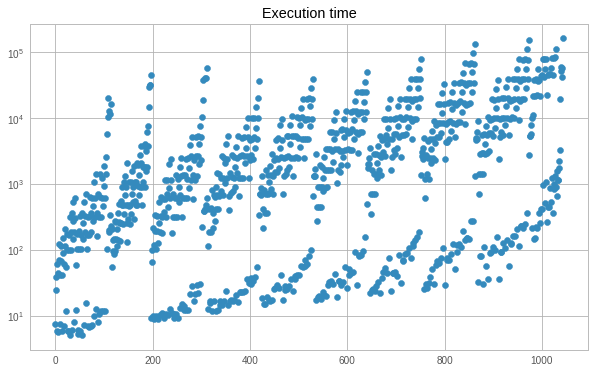

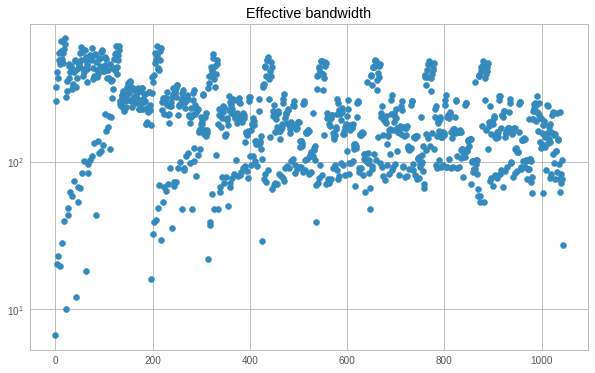

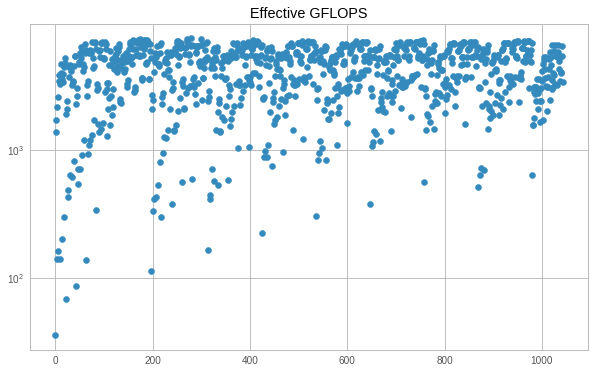

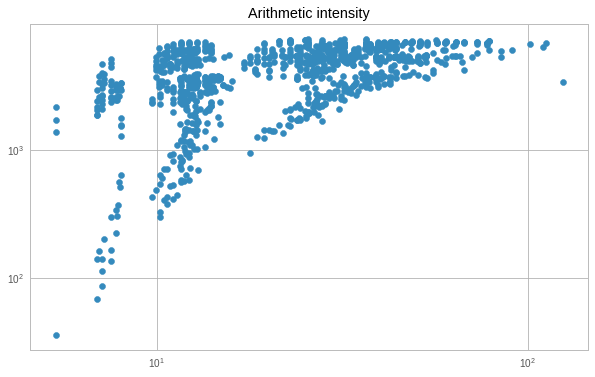

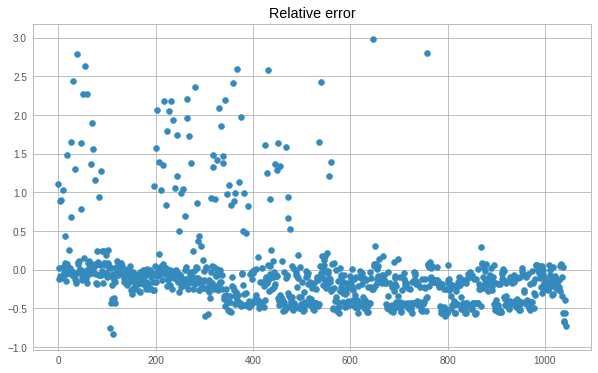

In [173]:
x = stats.sort_values(["K", "M", "N"])
x = x[(x["M"] >= 64) & (x["N"] >= 64) & (x["K"] >= 64)]

plt.figure(figsize=(10,6))
plt.scatter(range(len(x["kernel_runtime"])), x["kernel_runtime"])
plt.yscale("log")
plt.title("Execution time")

FLOP = x["batch_size"] * x["M"] * x["N"] * x["K"]
DRAM_bytes = x["batch_size"] * (x["M"] * x["K"] + x["K"] * x["N"] + x["M"] * x["N"]) * 4

effective_BW = DRAM_bytes / x["kernel_runtime"] / 1000
plt.figure(figsize=(10,6))
plt.scatter(range(len(effective_BW)), effective_BW)
plt.yscale("log")
plt.title("Effective bandwidth")

effective_FLOPS = FLOP / x["kernel_runtime"] / 1000
plt.figure(figsize=(10,6))
plt.scatter(range(len(effective_FLOPS)), effective_FLOPS)
plt.yscale("log")
plt.title("Effective GFLOPS")

AI = FLOP / DRAM_bytes
plt.figure(figsize=(10,6))
plt.scatter(AI, FLOP / x["kernel_runtime"] / 1000) 
plt.yscale("log")
plt.xscale("log")
plt.title("Arithmetic intensity")

DRAM_traffic_time = x["batch_size"] * (x["M"] * x["K"] + x["K"] * x["N"] + x["M"] * x["N"]) * 4 / (x["dram_read_throughput"] + x["dram_write_throughput"]) / 1000
compute_time = x["batch_size"] * x["M"] * x["N"] * x["K"] / 12200.0 / 1000
t = pd.concat([DRAM_traffic_time, compute_time], axis=1).max(axis=1)
ratio = (t - x["kernel_runtime"]) / x["kernel_runtime"]
plt.figure(figsize=(10, 6))
plt.scatter(range(len(ratio)), ratio)
plt.title("Relative error")

histogram(ratio, [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0, 2.0, 3.0, 4.0])
print(gmean(abs(ratio)), abs(ratio).mean(), abs(ratio).std())

In [174]:
def get_record(df, **kwargs):
    row_count = df.shape[0]
    condition = pd.Series([True] * row_count)
    for k, v in kwargs.items():
        condition = condition & (df[k] == v)
    return df[condition]

def get_closest(df, **kwargs):
    no_match = {}
    row_count = df.shape[0]
    condition = pd.Series([True] * row_count)
    for k, v in kwargs.items():
        if v in df[k].unique():
            condition = condition & (df[k] == v)
        else:
            no_match[k] = v

    # With matched dimensions
    data_points = [(df[condition], {})]
    
    # For each of the non-matched dimension
    for k, v in no_match.items():
        tmp = []
        for dp, limits in data_points:
            uni_val = sorted(dp[k].unique())
        
            low, high = -1, -1
            if v < uni_val[0]:
                high = uni_val[0]
            elif v > uni_val[-1]:
                low = uni_val[-1]
            else:
                for idx in range(len(uni_val[:-1])):
                    if uni_val[idx] < v and uni_val[idx+1] > v:
                        high = uni_val[idx+1]
                        low = uni_val[idx]
                        break
            assert not (low == -1 and high == -1)

            less_tmp = dp[dp[k] == (low if low != -1 else uni_val[0])]
            more_tmp = dp[dp[k] == (high if high != -1 else uni_val[-1])]
            if low == -1:
                less_tmp[k] = 0
            if high == -1:
                more_tmp[k] = sys.maxsize # Big enough for BW in GB/s or throughput in GFLOPS
            tmp_limits = limits.copy()
            tmp_limits[k] = (low, high)
            tmp.append((less_tmp, tmp_limits))
            tmp.append((more_tmp, tmp_limits))
        data_points = tmp
    
    return data_points

#####################
#       |     X |
#    |==O=======|
#    |  |       |
#    |  |-------O-
#    |     X     |
#    O           |
#    |===========O
#    |  X        |
#####################

def predict(df, **kwargs):
    record = get_record(df, **kwargs)
    if not record.empty:
        return record["kernel_runtime"].iloc[0]
    data_points = get_closest(df, **kwargs)
    
    effective_flops = 0.0
    effective_bw = 0.0
    batch_size = kwargs["batch_size"]
    M = kwargs["M"]
    N = kwargs["N"]
    K = kwargs["K"]
    for dp, limits in data_points:
        dp_flops_contrib = 0.0
        dp_bw_contrib = 0.0
        
        # An idea, if zero occurs, it's always the bottleneck. A zero dominates all peaks.
        zero_exists = False
        peak_exists = False
        for k, v in limits.items():
            metric = dp[k].iloc[0]
            if metric == 0:
                zero_exists = True
            elif metric == sys.maxsize:
                peak_exists = True
            
        for k, v in limits.items():
            low, high = v
            if high == -1: # Reaching the peak, taking average
                ratio_l, ratio_h = 0.5, 0.5
            elif low == -1: # Reaching the bottom, set low as 0
                ratio_l, ratio_h = kwargs[k] / high, (high - kwargs[k]) / high
            else: # Normal, weighted
                ratio_l, ratio_h = (kwargs[k] - low) / (high - low), (high - kwargs[k]) / (high - low)
            # Edge cases: when more than one metric is MAX/0
            
            metric = dp[k].iloc[0]
            if zero_exists:
                throughput = 0
                dram_bw = 0
                ratio = 0
            elif peak_exists:
                throughput = peak_throughput
                dram_bw = peak_dram_bw
                ratio = ratio_h
            elif metric == low:
                throughput = (dp["batch_size"] * dp["M"] * dp["N"] * dp["K"]).iloc[0] / dp["kernel_runtime"].iloc[0] / 1000 # GFLOPS
                dram_bw = (dp["batch_size"] * (dp["M"] * dp["K"] + dp["K"] * dp["N"] + dp["M"] * dp["N"])).iloc[0] / dp["kernel_runtime"].iloc[0] / 1000 * 4 # GB/s
                ratio = ratio_l 
            elif metric == high:
                throughput = (dp["batch_size"] * dp["M"] * dp["N"] * dp["K"]).iloc[0] / dp["kernel_runtime"].iloc[0] / 1000 # GFLOPS
                dram_bw = (dp["batch_size"] * (dp["M"] * dp["K"] + dp["K"] * dp["N"] + dp["M"] * dp["N"])).iloc[0] / dp["kernel_runtime"].iloc[0] / 1000 * 4 # GB/s
                ratio = ratio_h
                
            dp_flops_contrib += throughput * ratio
            dp_bw_contrib += dram_bw * ratio

        effective_flops += dp_flops_contrib / len(limits.items())
        effective_bw += dp_bw_contrib / len(limits.items())

    effective_flops /= len(data_points) / 2
    effective_bw /= len(data_points) / 2
    
    FLOP = kwargs["batch_size"] * kwargs["M"] * kwargs["N"] * kwargs["K"]
    DRAM_bytes = kwargs["batch_size"] * (kwargs["M"] * kwargs["K"] + kwargs["K"] * kwargs["N"] + kwargs["M"] * kwargs["N"]) * 4
    predicted_runtime = max(FLOP / effective_flops, DRAM_bytes / effective_bw) / 1000
    
#     print(kwargs["batch_size"], kwargs["M"], kwargs["N"], kwargs["K"], predicted_runtime)
    
    return predicted_runtime
    
# predict(addmm, batch_size=1, M=32768, N=512, K=4096)
# predict(addmm, batch_size=1, M=32768, N=215, K=1500)
# predict(stats, batch_size=1, M=50, N=1000, K=10)
predict(stats, batch_size=512, M=50, N=50, K=10)

117.96006474336319

In [283]:
filename = "./fully_connected_test.csv"
test = pd.read_csv(filename, delimiter=',')
test = preprocessing(test)
test = test[test["kernel_name"].str.startswith("volta")]
# test.head()

0.0-5.0%, 17.29%
5.0-10.0%, 10.93%
10.0-15.0%, 7.99%
15.0-20.0%, 10.28%
20.0-25.0%, 7.50%
25.0-30.0%, 6.04%
30.0-100.0%, 37.85%
100.0-200.0%, 1.14%
200.0-300.0%, 0.98%
300.0-400.0%, 0.00%
GMAE: 16.11%, mean: 29.35%, std: 32.27%


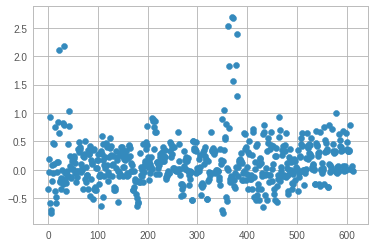

In [286]:
# s = test
s = test[(test["M"] >= min(stats["M"].unique())) & (test["M"] <= max(stats["M"].unique())) & \
        (test["N"] >= min(stats["N"].unique())) & (test["N"] <= max(stats["N"].unique())) & \
        (test["K"] >= min(stats["K"].unique())) & (test["K"] <= max(stats["K"].unique()))]

t = s.apply(lambda x: predict(stats, batch_size=x["batch_size"], M=x["M"], N=x["N"], K=x["K"]), axis=1)
ratio = (t - s["kernel_runtime"]) / s["kernel_runtime"]
plt.figure()
plt.scatter(range(len(ratio)), ratio)

histogram(ratio, [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0, 2.0, 3.0, 4.0])
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmean(abs(ratio)) * 100, abs(ratio).mean() * 100, abs(ratio).std() * 100))